In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.rdmolops import FindPotentialStereo
# Alter here only

# Cria a variável que contem a lista de arqquivos que voce quer olhar, se for só um deixa como string
path_to_files = "D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results"
# To get from a directory                          
# troca os.listdir por um método semelhante que percorra o drive
files = [f"{path_to_files}/{file}" for file in os.listdir(path_to_files)]
print(files)
name = [f"{file.strip('.xlsx')}" for file in os.listdir(path_to_files)]
name = [f"{n.strip('.csv')}" for n in name]
your_smiles = "Chemical Structure"
your_values = "Dose"
your_study_type = "EC50"
result_name="Sparse_Hepatotox"

['D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results/Cholestasis.csv', 'D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results/Cholestatic Jaundice.csv', 'D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results/Filtered Abnormal Hepatic Fun .csv', 'D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results/Filtered Acute Hepatitis.csv', 'D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results/Filtered Autoimune hepatitis.csv', 'D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results/Filtered Cholecystitis.csv', 'D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results/Filtered Cholelitiasis.csv', 'D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results/Filtered Cholestasiss.csv', 'D:\\Projetos academicos\\Lab

Convert to csv 

In [2]:
for file in files:
    if file.find(".xlsx")!=-1:
        for sheet in pd.ExcelFile(file).sheet_names:
            df = pd.read_excel(file,sheet_name=sheet)
            df.to_csv(f"{name}_{sheet}.csv",index=False)

In [19]:
def organize(all_df):
    #smiles_list=[]
    df_smiles=[]
    for i,df in enumerate(all_df):
        smiles = df.loc[:,your_smiles]
        smiles_col = f"Smiles {i}"
              
        df_smiles.append(df.loc[:,[your_smiles,your_values]])
        df = df_smiles[i]
        df = df.dropna(axis=0, how='all')
        df = df.rename(columns={your_values:f"{your_study_type}_{i}",your_smiles:smiles_col})

        #mols = []
        canon_smiles = []
        inchik = []
        #smiles_s = df[smiles_col]
        for ds in smiles:
            try:
                cs = Chem.CanonSmiles(ds)
                mol = Chem.MolFromSmiles(cs)
                inchik.append(Chem.rdinchi.MolToInchiKey(mol))
                canon_smiles.append(cs)
            except:
                df.drop(index=i,drop=True,inplace=True)
                df.reset_index(drop=True, inplace=True)
        #print(len(inchik))
        df=df.drop(smiles_col, axis=1)
        
        df["Inchi"] = inchik
        df["SMILES"] = canon_smiles
        df_smiles[i] = df
        if i == 0:
            df_all_inchi = df
        elif i == 1: 
        
            prev_df = df_smiles[i-1]
        
            # df_all_inchi=pd.merge(df,prev_df, how="outer", on="SMILES")
        
            df_all_inchi = pd.merge(df,prev_df, how = "outer", on = ["Inchi","SMILES"])
        
        elif i > 1:

        # df_all_inchi=pd.merge(df_all_inchi,df, how="outer",on="SMILES")
        
            df_all_inchi=pd.merge(df_all_inchi,df,how="outer", on=["Inchi","SMILES"])

    df_all=df_all_inchi.drop("Inchi", axis=1)
    return df_all
    

def read_through_files(files):
        df=[]
        if type(files) is str:
            # name=result_name
            # name=name.replace(".xlsx","")
            # name=name.replace(".csv","")
            if files.find(".csv")!=-1:
                df.append(pd.read_csv(files,delimiter=","))
                #organize(df,name)
            else:
                sheets = pd.ExcelFile(files).sheet_names
                if len(sheets)>1:
                    for sheet in sheets:
                        if sheet != ".":
                            #name=sheet
                            df.append(pd.read_excel(files,sheet_name=sheet))
                            #organize(df,name)
                else:
                    for sheet in sheets:
                        if sheet != ".":
                            #name=sheet
                            df.append(pd.read_excel(files,sheet_name=sheet))
        else:
            for file in files:
                if file.find(".csv")!=-1:
                    df.append(pd.read_csv(file,delimiter=","))
                else:   
                    sheets = pd.ExcelFile(file).sheet_names
                    if len(sheets)>1:
                        for sheet in sheets:
                            if sheet != ".":
                                #name=sheet
                                df.append(pd.read_excel(file,sheet_name=sheet))
                                #organize(df,name)
                    else:
                        for sheet in sheets:
                            if sheet != ".":
                                #name=sheet
                                df.append(pd.read_excel(file,sheet_name=sheet))
        return organize(df)
df = read_through_files(files=files)
df.to_csv(f"./results/{result_name}.csv",index=False)

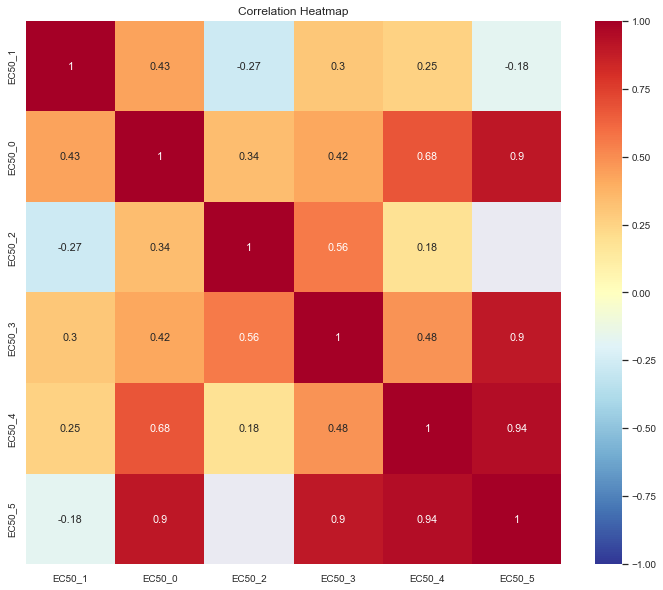

In [20]:
correlation_df=pd.read_csv(f"./results/{result_name}.csv")
corr=correlation_df.corr()
sns.set_style('darkgrid')
sns.set(font_scale=0.9, rc={'figure.figsize':(12,10)})
sns.heatmap(corr, cmap='RdYlBu_r', vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap', fontsize=12)
plt.savefig('Correlation.png', bbox_inches='tight',
            transparent=True, format='png', dpi=400)